# Training Notebook

Train the CatMeowCNN model on preprocessed data.


In [1]:
import sys
from pathlib import Path

# Add src to path
sys.path.insert(0, str(Path("..").resolve()))
sys.path.insert(0, str(Path("../src").resolve()))

from src.data_loader import load_train_data, load_test_data, get_train_val_loaders, get_test_loader
from src.train import train, cross_validate
from src.test import test
from src.transforms import SpecAugment, Compose, RandomApply, AddNoise
from models import CatMeowCNN
import matplotlib.pyplot as plt
import torch



## 1. Load Data


In [2]:
DATA_DIR = Path("../data/interim")
MODEL_PATH = Path("../results/cat_meow.pt")

# Ensure results dir exists
MODEL_PATH.parent.mkdir(parents=True, exist_ok=True)

# Load train and test separately
X_train, y_train = load_train_data(DATA_DIR)
X_test, y_test = load_test_data(DATA_DIR)

print(f"Train: X={X_train.shape}, y={y_train.shape}")
print(f"Test:  X={X_test.shape}, y={y_test.shape}")
print(f"Classes: {len(set(y_train))}")


Train: X=(80, 128, 173), y=(80,)
Test:  X=(20, 128, 173), y=(20,)
Classes: 10


In [3]:
# Augmentation for training
train_transform = Compose([
    SpecAugment(freq_mask_param=15, time_mask_param=25),
    RandomApply(AddNoise(noise_level=0.005), p=0.3),
])

# Split training data into train/val
train_loader, val_loader = get_train_val_loaders(
    X_train, y_train, batch_size=16, train_transform=train_transform
)
print(f"Train: {len(train_loader.dataset)} samples (with augmentation)")
print(f"Val: {len(val_loader.dataset)} samples")
print(f"Test: {len(X_test)} samples (held out)")


Train: 64 samples (with augmentation)
Val: 16 samples
Test: 20 samples (held out)


## 2. Create Model


In [4]:
n_classes = len(set(y_train))
model = CatMeowCNN(n_classes=n_classes)

n_params = sum(p.numel() for p in model.parameters())
print(f"Model: CatMeowCNN")
print(f"Parameters: {n_params:,}")


Model: CatMeowCNN
Parameters: 422,986


## 3. Train


In [5]:
# Train a final model and evaluate on test set
model = CatMeowCNN(n_classes=n_classes)

# Get fresh loaders
train_loader, val_loader = get_train_val_loaders(
    X_train, y_train, batch_size=16, train_transform=train_transform
)

history = train(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=100,
    learning_rate=0.001,
    save_path=str(MODEL_PATH),
    patience=40,
)


Epoch   1/100 | Train: 2.3303, 0.125 | Val: 2.2802, 0.125
  -> Saved (val_acc: 0.125)
Epoch   2/100 | Train: 2.2584, 0.156 | Val: 2.3097, 0.125
Epoch   3/100 | Train: 2.1618, 0.172 | Val: 2.3063, 0.125
Epoch   4/100 | Train: 2.0349, 0.312 | Val: 2.2425, 0.125
Epoch   5/100 | Train: 2.0178, 0.250 | Val: 2.1227, 0.125
Epoch   6/100 | Train: 2.0099, 0.250 | Val: 1.9903, 0.125
Epoch   7/100 | Train: 1.9955, 0.312 | Val: 1.9115, 0.188
  -> Saved (val_acc: 0.188)
Epoch   8/100 | Train: 1.8578, 0.359 | Val: 1.8743, 0.312
  -> Saved (val_acc: 0.312)
Epoch   9/100 | Train: 1.8489, 0.359 | Val: 1.8408, 0.250
Epoch  10/100 | Train: 1.7348, 0.469 | Val: 1.8122, 0.312
Epoch  11/100 | Train: 1.7492, 0.375 | Val: 1.8264, 0.250
Epoch  12/100 | Train: 1.7206, 0.391 | Val: 1.8354, 0.312
Epoch  13/100 | Train: 1.8186, 0.250 | Val: 1.7635, 0.312
Epoch  14/100 | Train: 1.6561, 0.438 | Val: 1.6500, 0.312
Epoch  15/100 | Train: 1.6113, 0.406 | Val: 1.6318, 0.438
  -> Saved (val_acc: 0.438)
Epoch  16/100 | Tr

## 5. Evaluate


In [6]:
# Load best model and evaluate on held-out test data
model.load_state_dict(torch.load(MODEL_PATH, weights_only=True))
test_loader = get_test_loader(X_test, y_test)
results = test(model, test_loader)


Test Loss: 1.7507
Test Accuracy: 0.500


## 6. Cross-Validation

Run k-fold cross-validation for a more reliable accuracy estimate with limited data.


In [7]:
# Run 5-fold cross-validation on training data
cv_results = cross_validate(
    model_class=CatMeowCNN,
    X=X_train,
    y=y_train,
    n_splits=5,
    epochs=100,
    learning_rate=0.001,
    batch_size=16,
    patience=40,
    n_classes=n_classes,  # passed to CatMeowCNN
)



Fold 1/5
Epoch   1/100 | Train: 2.3298, 0.109 | Val: 2.3600, 0.062
Epoch   2/100 | Train: 2.1751, 0.266 | Val: 2.3948, 0.062
Epoch   3/100 | Train: 2.0811, 0.297 | Val: 2.3152, 0.062
Epoch   4/100 | Train: 1.9749, 0.344 | Val: 2.1258, 0.125
Epoch   5/100 | Train: 1.9065, 0.438 | Val: 2.0228, 0.188
Epoch   6/100 | Train: 1.8786, 0.375 | Val: 1.8480, 0.312
Epoch   7/100 | Train: 1.7153, 0.453 | Val: 1.7476, 0.312
Epoch   8/100 | Train: 1.6679, 0.516 | Val: 1.7755, 0.250
Epoch   9/100 | Train: 1.6391, 0.422 | Val: 1.8012, 0.250
Epoch  10/100 | Train: 1.5352, 0.500 | Val: 1.6799, 0.250
Epoch  11/100 | Train: 1.5318, 0.453 | Val: 1.6163, 0.312
Epoch  12/100 | Train: 1.3290, 0.594 | Val: 1.7151, 0.188
Epoch  13/100 | Train: 1.4230, 0.562 | Val: 1.6060, 0.375
Epoch  14/100 | Train: 1.3750, 0.531 | Val: 1.5420, 0.438
Epoch  15/100 | Train: 1.3509, 0.562 | Val: 1.8427, 0.375
Epoch  16/100 | Train: 1.2240, 0.641 | Val: 1.5818, 0.438
Epoch  17/100 | Train: 1.1535, 0.609 | Val: 1.4814, 0.438
Epoc

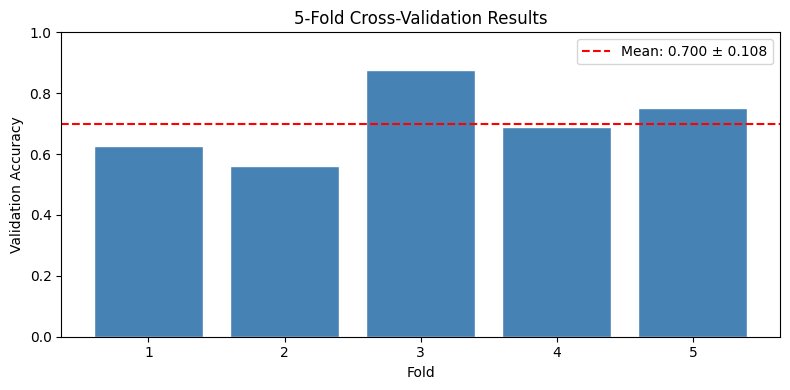


CV Accuracy: 70.0% ± 10.8%


In [8]:
# Visualize CV results
fig, ax = plt.subplots(figsize=(8, 4))
folds = [r["fold"] for r in cv_results["fold_results"]]
accs = cv_results["accuracies"]

ax.bar(folds, accs, color='steelblue', edgecolor='white')
ax.axhline(cv_results["mean_acc"], color='red', linestyle='--', 
           label=f'Mean: {cv_results["mean_acc"]:.3f} ± {cv_results["std_acc"]:.3f}')
ax.set_xlabel("Fold")
ax.set_ylabel("Validation Accuracy")
ax.set_title("5-Fold Cross-Validation Results")
ax.set_ylim(0, 1)
ax.legend()
plt.tight_layout()
plt.show()

print(f"\nCV Accuracy: {cv_results['mean_acc']:.1%} ± {cv_results['std_acc']:.1%}")


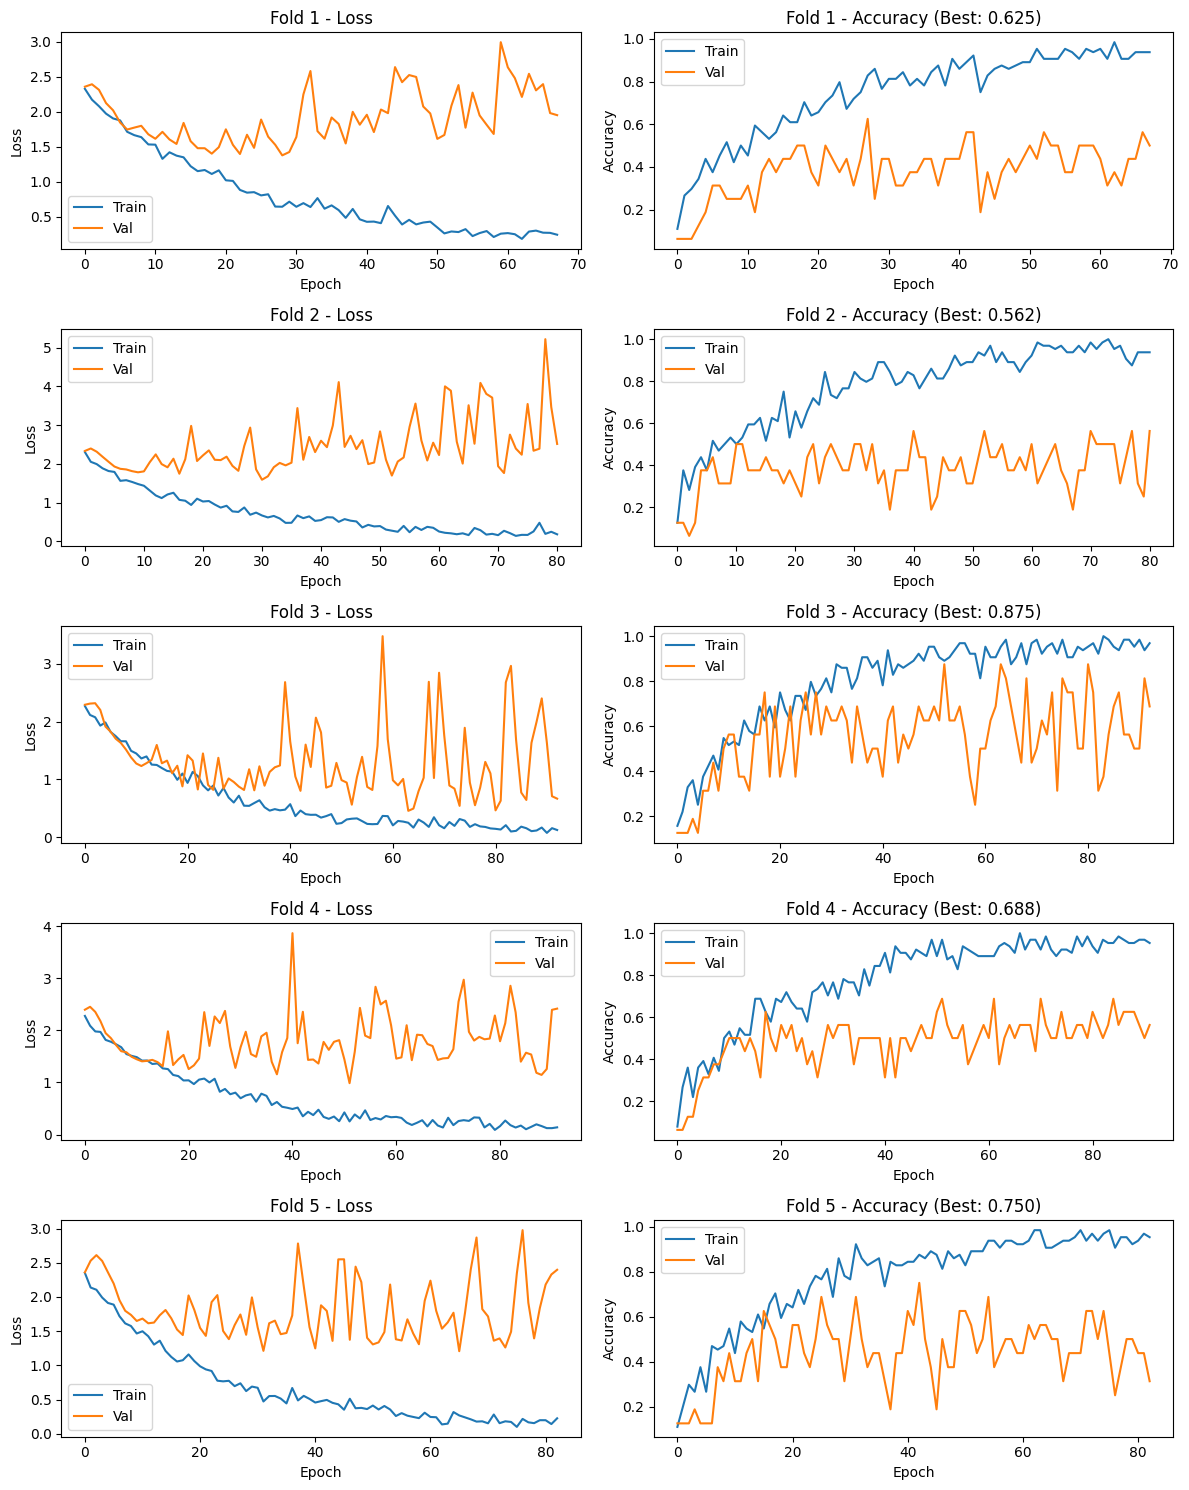

In [9]:
# Plot training curves for each fold
n_folds = len(cv_results["fold_results"])
fig, axes = plt.subplots(n_folds, 2, figsize=(12, 3 * n_folds))

for i, fold_result in enumerate(cv_results["fold_results"]):
    fold_history = fold_result["history"]
    fold_num = fold_result["fold"]
    
    # Loss
    axes[i, 0].plot(fold_history["train_loss"], label="Train")
    axes[i, 0].plot(fold_history["val_loss"], label="Val")
    axes[i, 0].set_xlabel("Epoch")
    axes[i, 0].set_ylabel("Loss")
    axes[i, 0].set_title(f"Fold {fold_num} - Loss")
    axes[i, 0].legend()
    
    # Accuracy
    axes[i, 1].plot(fold_history["train_acc"], label="Train")
    axes[i, 1].plot(fold_history["val_acc"], label="Val")
    axes[i, 1].set_xlabel("Epoch")
    axes[i, 1].set_ylabel("Accuracy")
    axes[i, 1].set_title(f"Fold {fold_num} - Accuracy (Best: {fold_result['best_val_acc']:.3f})")
    axes[i, 1].legend()

plt.tight_layout()
plt.show()


## 8. Save Results for Diagnostics


In [10]:
# Save all training results for diagnostics notebook
import pickle

RESULTS_DIR = Path("../results")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

# Bundle all results
training_results = {
    "history": history,
    "cv_results": cv_results,
    "test_results": results,
    "n_classes": n_classes,
}

with open(RESULTS_DIR / "training_results.pkl", "wb") as f:
    pickle.dump(training_results, f)

print(f"Saved training results to {RESULTS_DIR / 'training_results.pkl'}")
print(f"  - Training history: {len(history['train_loss'])} epochs")
print(f"  - CV results: {len(cv_results['fold_results'])} folds")
print(f"  - Test accuracy: {results['accuracy']:.1%}")


Saved training results to ../results/training_results.pkl
  - Training history: 100 epochs
  - CV results: 5 folds
  - Test accuracy: 50.0%
